Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
root_dir = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration"

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(root_dir + "/Train")
data_dir_test = pathlib.Path(root_dir + "/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

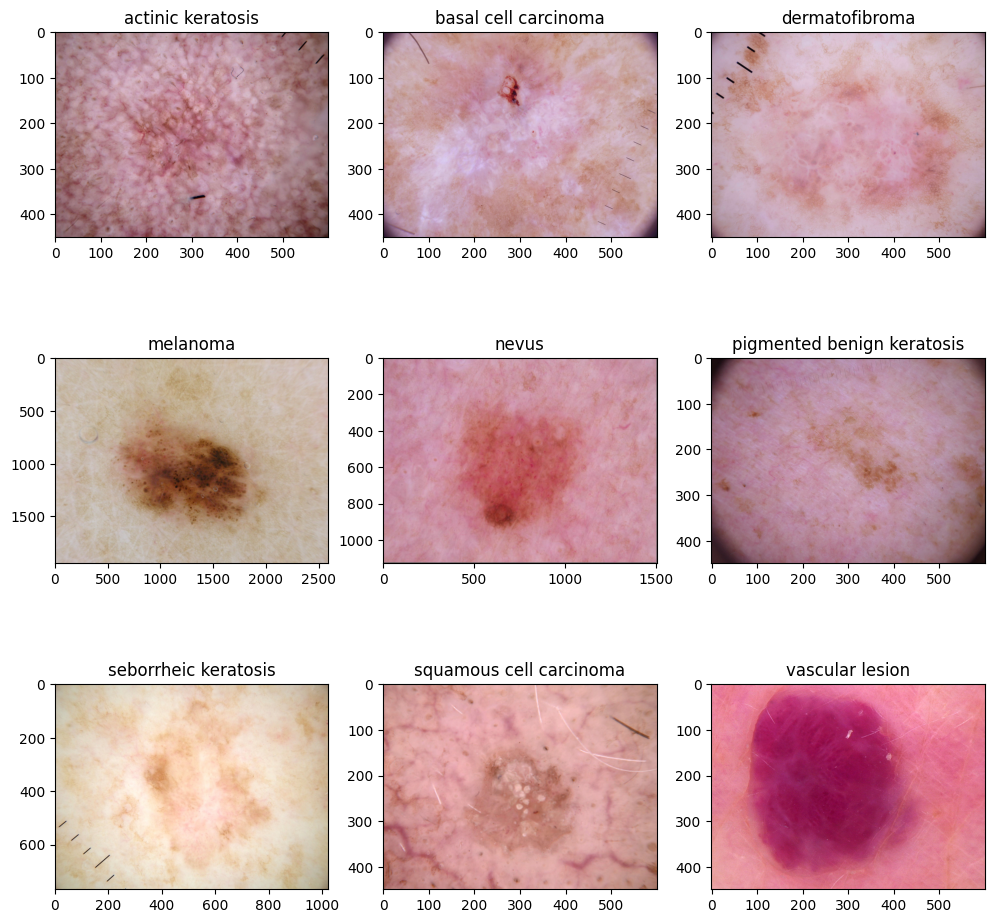

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12,12))
for i in range(len(class_names)):
    plt.subplot(3,3,i+1)
    imgValue = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(imgValue)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the first model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
from keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPool2D
classes_num = 9
model_1 = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3))
])
# Creating Convolution layer with 64 features, 3x3 filter and activation function as relu  with 2x2 pooling
model_1.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model_1.add(layers.MaxPooling2D())

# Creating Convolution layer with 128 features, 3x3 filter and activation function as relu with 2x2 pooling
model_1.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model_1.add(layers.MaxPooling2D())

model_1.add(Flatten())

model_1.add(Dense(256,activation='relu'))#added
model_1.add(Dense(classes_num,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 259200)            0

### Train the model

In [15]:
epochs = 20
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 190s 2s/step - loss: 2.9365 - accuracy: 0.2031 - val_loss: 1.9519 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 4s 71ms/step - loss: 1.7837 - accuracy: 0.3298 - val_loss: 1.7806 - val_accuracy: 0.3870
Epoch 3/20
56/56 [==============================] - 4s 67ms/step - loss: 1.5690 - accuracy: 0.4414 - val_loss: 1.5050 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 4s 67ms/step - loss: 1.4457 - accuracy: 0.5017 - val_loss: 1.7488 - val_accuracy: 0.4027
Epoch 5/20
56/56 [==============================] - 4s 70ms/step - loss: 1.3494 - accuracy: 0.5368 - val_loss: 1.4166 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 4s 67ms/step - loss: 1.1975 - accuracy: 0.5798 - val_loss: 1.4673 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.0640 - accuracy: 0.6256 - val_loss: 1.5961 - val_accuracy: 0.4944
Epoch 8/20
56

### Visualizing training results

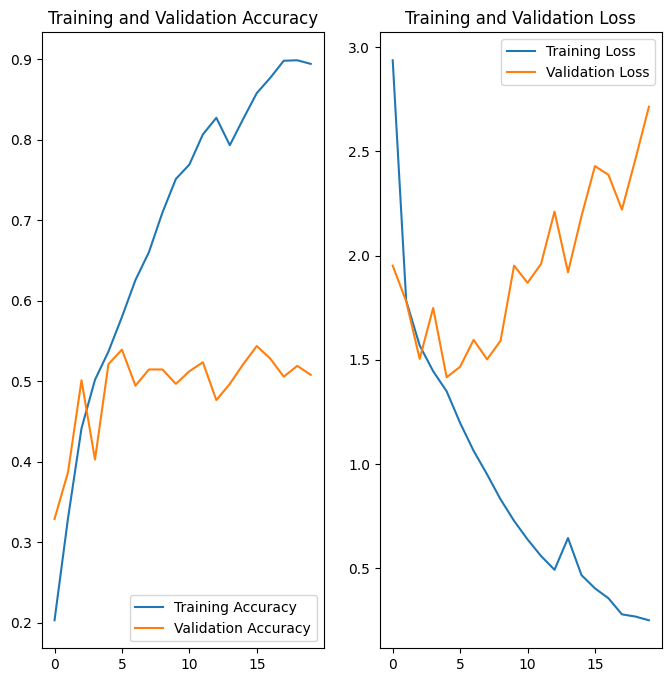

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Findings from First model:--**
##### We can infer from the above graph that
1. The validation accuracy stall at ~51% accuracy in training process, where as the training accuracy increases over time .
1. The training loss dereases with each epochs while the validation loss increases.
1. Training accuracy and validation accuracy are off by a large margin, as model has achieved training accuracy of <b>~89%</b> while it has achieved around <b>51%</b> accuracy on the validation set.
1. The difference between training and validation accuracy is <b>very huge</b> which in turn is a sign of <b><u>overfitting</u></b>.

In [17]:
# We observed that our model is overfitting. To handle this, We can introduce more sample by augmenting the exisiting images.
# Augmentation Strategies chosen
# 1. Random Flip around horizontal axis.
# 2. Random Rotation
# 3. Random Zoom

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

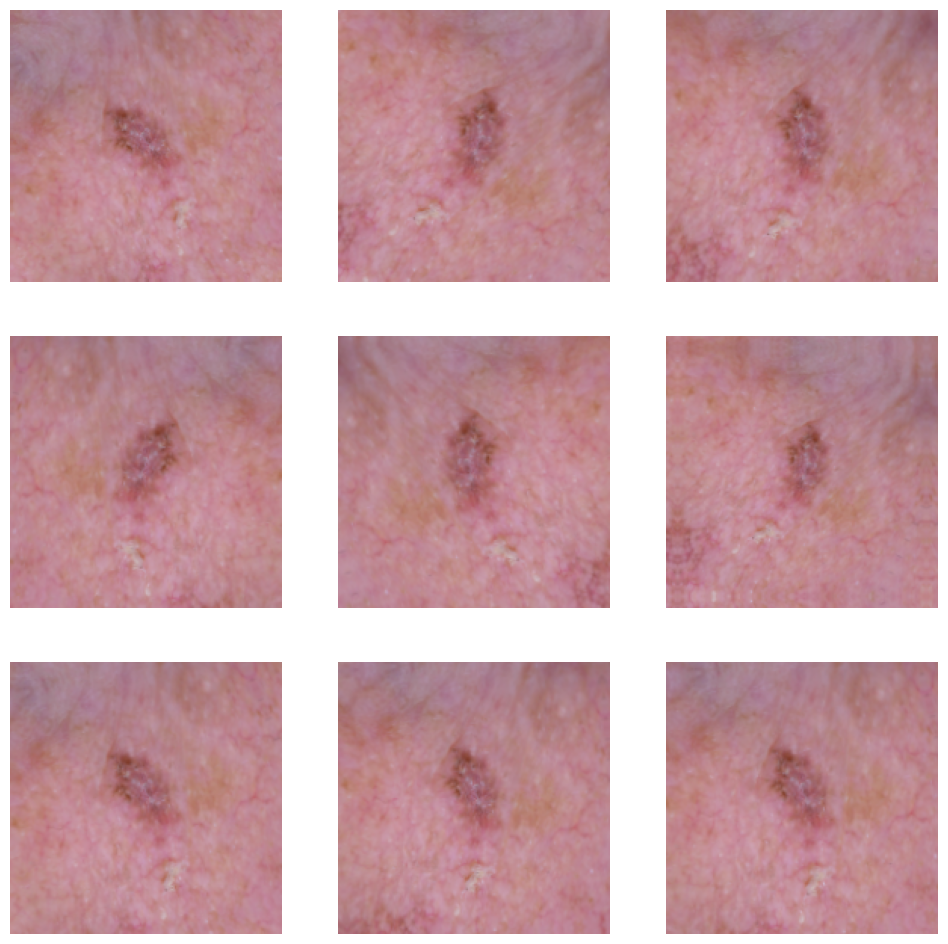

In [18]:
# Visualizing the augmentation strategy

plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_img = data_augmentation(images)
    plt.imshow(augmented_img[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the second model with the augmentation strategy.
### Create the model, compile and train the model


In [19]:
## We have used Dropout layer since there is an evidence of overfitting in your findings

model_2 = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3))
])
# Creating Convolution layer with 64 features, 3x3 filter and activation function as relu  with 2x2 pooling
model_2.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model_2.add(layers.MaxPooling2D())

# Creating Convolution layer with 128 features, 3x3 filter and activation function as relu with 2x2 pooling
model_2.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model_2.add(layers.MaxPooling2D())
# Now this time adding a 20% dropout after the convolution layers
model_2.add(layers.Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(256,activation='relu'))#added
model_2.add(Dense(classes_num,activation='softmax'))


### Compiling the model

In [20]:
# compiling the model
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# Showing the Summary of all the layer in model_2
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

### Training the model

In [21]:
## Training the model for 20 epochs
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 114ms/step - loss: 2.9331 - accuracy: 0.2556 - val_loss: 1.8843 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 6s 112ms/step - loss: 1.7557 - accuracy: 0.3627 - val_loss: 1.6295 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 6s 113ms/step - loss: 1.6004 - accuracy: 0.4397 - val_loss: 1.5084 - val_accuracy: 0.4698
Epoch 4/20
56/56 [==============================] - 6s 111ms/step - loss: 1.5033 - accuracy: 0.4771 - val_loss: 1.5175 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 6s 110ms/step - loss: 1.4171 - accuracy: 0.5061 - val_loss: 1.4064 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 6s 110ms/step - loss: 1.4123 - accuracy: 0.4983 - val_loss: 1.4995 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 6s 112ms/step - loss: 1.3662 - accuracy: 0.5240 - val_loss: 1.5162 - val_accuracy: 0.4877
Epoch 

### Visualizing the results

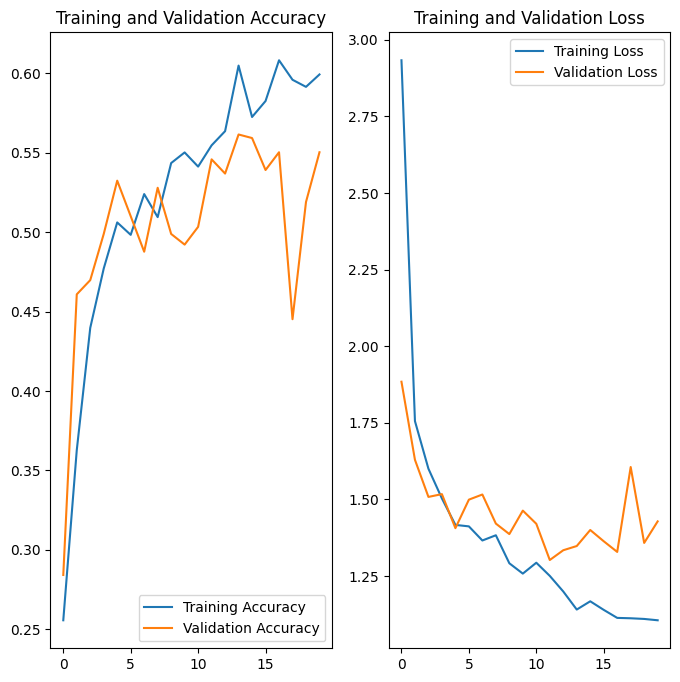

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Findings from Second model:--**
##### We can infer from above graph that
1. The training accuracy increases over time, where as the validation accuracy increases and stall at 55% accuracy during training process.
1. <b>Both training loss as well as validation loss decreases during training process with each epochs.</b>
1. The gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>55%</b> accuracy on the validation set.
1. The difference in accuracy between training and validation is <b>very less</b>, which is good as it signifies that model has not overfit.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

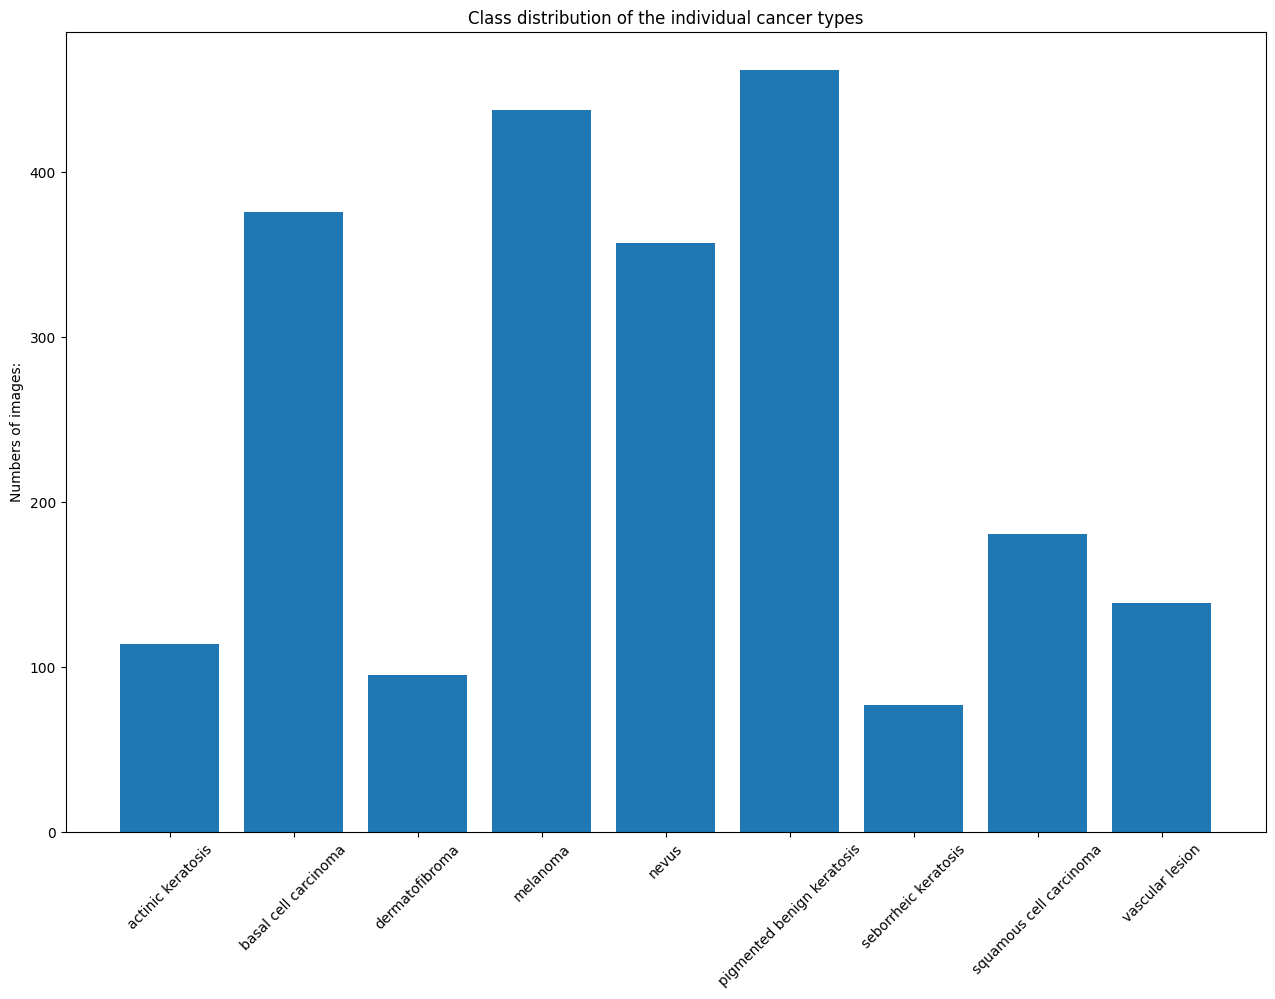

In [23]:
# Plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images:')
ax.set_title('Class distribution of the individual cancer types')
plt.xticks(rotation=45)
plt.show()

In [24]:
## Your code goes here.
for indx in range(len(class_names)):
  print(class_names[indx],' - ',len(list(data_dir_train.glob(class_names[indx]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


## Findings
#### 1.) Which class has the least number of samples?
#### Ans. 1) **seborrheic keratosis** has the least number of samples which is 77 in total.
#### 2.) Which classes dominate the data in terms proportionate number of samples?
#### Ans. 2) **pigmented benign keratosis** dominates with 462 samples in total.

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset= root_dir + "/Train/"
import Augmentor
for i in class_names:
    print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7876A38FB2B0>: 100%|██████████| 500/500 [00:24<00:00, 20.74 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7876A3FBFA30>: 100%|██████████| 500/500 [00:22<00:00, 22.34 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7876A0A7DCC0>: 100%|██████████| 500/500 [00:24<00:00, 20.80 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x787698229120>: 100%|██████████| 500/500 [01:30<00:00,  5.51 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7876A396B1F0>: 100%|██████████| 500/500 [01:20<00:00,  6.20 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7876A38C1DE0>: 100%|██████████| 500/500 [00:17<00:00, 28.04 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7876A3F261A0>: 100%|██████████| 500/500 [00:48<00:00, 10.31 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7876A971E380>: 100%|██████████| 500/500 [00:20<00:00, 24.48 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78769825B3D0>: 100%|██████████| 500/500 [00:18<00:00, 27.36 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_7bcea74b-debe-4bb4-9894-87e21e531a2e.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_63a297f2-d0b1-4697-9fdd-b68412ed37d8.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_2f2c0a19-97e3-4bbe-ba56-721d7841086c.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031823.jpg_5ea5046e-43ad-4d8e-87e9-f9b8b3e6451c.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028517.jpg_e622c1a1-566c

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [32]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [34]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating the model

In [36]:
## your code goes here
model_3 = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3))
])
# Creating Convolution layer with 64 features, 3x3 filter and activation function as relu  with 2x2 pooling
model_3.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model_3.add(layers.MaxPooling2D())

# Creating Convolution layer with 128 features, 3x3 filter and activation function as relu with 2x2 pooling
model_3.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model_3.add(layers.MaxPooling2D())
# Now this time adding a 20% dropout after the convolution layers
model_3.add(layers.Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(256,activation='relu'))#added
model_3.add(Dense(classes_num,activation='softmax'))

#### Compiling your model

In [37]:
# compiling the model
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# Showing the Summary of all the layer in model_2
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

#### Train your model

In [38]:
epochs = 30
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 56s 297ms/step - loss: 2.3180 - accuracy: 0.2819 - val_loss: 1.6956 - val_accuracy: 0.3571
Epoch 2/30
169/169 [==============================] - 39s 228ms/step - loss: 1.5241 - accuracy: 0.4212 - val_loss: 1.4274 - val_accuracy: 0.4566
Epoch 3/30
169/169 [==============================] - 41s 237ms/step - loss: 1.4395 - accuracy: 0.4579 - val_loss: 1.4312 - val_accuracy: 0.4647
Epoch 4/30
169/169 [==============================] - 42s 245ms/step - loss: 1.3661 - accuracy: 0.4777 - val_loss: 1.3053 - val_accuracy: 0.4981
Epoch 5/30
169/169 [==============================] - 42s 244ms/step - loss: 1.2942 - accuracy: 0.5141 - val_loss: 1.2148 - val_accuracy: 0.5397
Epoch 6/30
169/169 [==============================] - 42s 243ms/step - loss: 1.2366 - accuracy: 0.5258 - val_loss: 1.1963 - val_accuracy: 0.5449
Epoch 7/30
169/169 [==============================] - 40s 229ms/step - loss: 1.1799 - accuracy: 0.5525 - val_loss: 1.0737 - val_ac

#### Visualize the model results

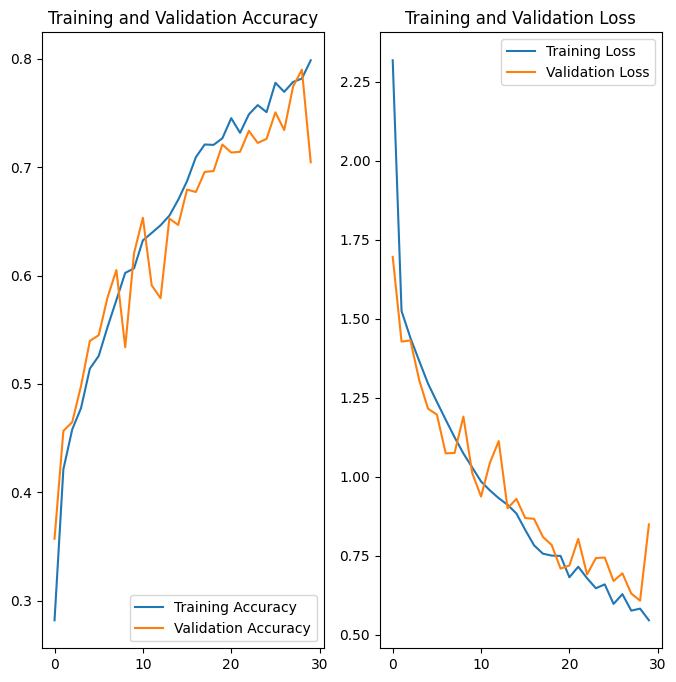

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### **Conclusion**:--

####  We can infer from the above graph that
1. Both training accuracy as well as validation accuracy increases over time as training progresses with each epochs.

1. Both training loss as well as validation loss decreases over time as training progresses with each epochs.

1. Gap/difference between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved accuracy in the range of <b>75%-80%</b> on the validation set.

1. The difference in accuracy between training and validation is very less, around(~1%) which is good. As it indicates that model has learn the hidden facts and has not overfitted.

### **Class rebalancing not only helps us got rid of overfitting but it also helped in improving the validation accuracy from ~55%(aaprox.) to ~78%(aaprox.).**